In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'axes.spines.top': False, 'axes.spines.right': False, 'savefig.dpi': 1200})
import numpy as np
import torch
from stable_baselines3 import PPO

from irc.environments import BeliefMDPEnvironment

from boxforage.single_box import SingleBoxForaging
from boxforage.utils import plot_single_box_trial

# Single Box Foraging Experiment

In [2]:
env_spec = {
    'box': {'p_true': 0.2, 'p_cue': 0.7},
    'reward': {'food': 5},
}
env = SingleBoxForaging(env_spec=env_spec)

num_steps = 80

evaluating agent with right model...
estimating prior distribution p(s)
10 epochs trained on 1000 samples, log likelihood -0.015 (0m00.22s)
estimating conditional distribution p(o|s)
10 epochs trained on 10000 samples, log likelihood -1.015 (0m35.87s)


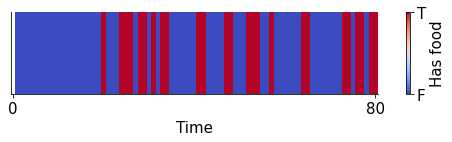

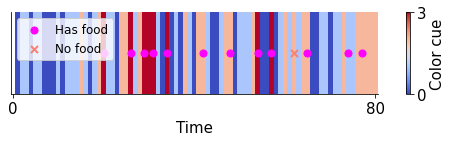

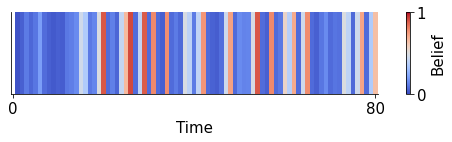

In [3]:
print('evaluating agent with right model...')
p_true, p_cue, r_food = 0.2, 0.7, 5.
env_spec_0 = {
    'box': {'p_true': p_true, 'p_cue': p_cue},
    'reward': {'food': r_food},
}
save_pth = 'store/{:02d}_{:d}_{:02d}.pt'.format(int(p_true*100), int(p_cue*10), int(r_food))
b_env_0 = BeliefMDPEnvironment(SingleBoxForaging(env_spec=env_spec_0))
algo_0 = PPO('MlpPolicy', env=b_env_0)
algo_0.policy.load_state_dict(torch.load(save_pth))
trial_0 = b_env_0.run_one_trial(algo=algo_0, env=env, num_steps=num_steps)
figs = plot_single_box_trial(b_env_0, trial_0)

evaluating agent with wrong model...
estimating prior distribution p(s)
10 epochs trained on 1000 samples, log likelihood -0.015 (0m00.22s)
estimating conditional distribution p(o|s)
10 epochs trained on 10000 samples, log likelihood -0.558 (0m39.17s)


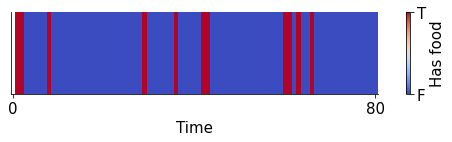

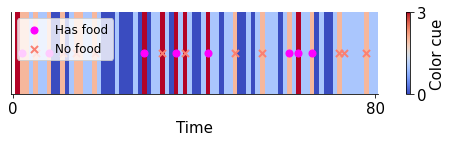

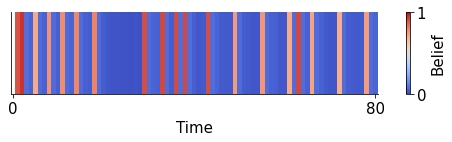

In [4]:
print('evaluating agent with wrong model...')
p_true, p_cue, r_food = 0.05, 0.9, 10.
env_spec_1 = {
    'box': {'p_true': p_true, 'p_cue': p_cue},
    'reward': {'food': r_food},
}
save_pth = 'store/{:02d}_{:d}_{:02d}.pt'.format(int(p_true*100), int(p_cue*10), int(r_food))
b_env_1 = BeliefMDPEnvironment(SingleBoxForaging(env_spec=env_spec_1))
algo_1 = PPO('MlpPolicy', env=b_env_1)
algo_1.policy.load_state_dict(torch.load(save_pth))
trial_1 = b_env_1.run_one_trial(algo=algo_1, env=env, num_steps=num_steps)
figs = plot_single_box_trial(b_env_1, trial_1)